Vamos a crear unos datos MUYYY sencillitos, y vamos a entrenar el modelo en RECONSTRUIRLOS solo. No vamos a pretender que haga nada más.   
Luego le meteremos lo de al AssDis.

In [1]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

# Los datos sinteticos SIN ANOMALÍAS

Voy a hacer un generador que nos de una secuencia regular, con puntos de anomalia


In [2]:
def sinne(lenght=100,amp=1,sf=0.1,f=2,phase=0):
    x = torch.arange(0,lenght*sf, sf)
    return amp*torch.sin(x*sf*2*torch.pi/f+phase)


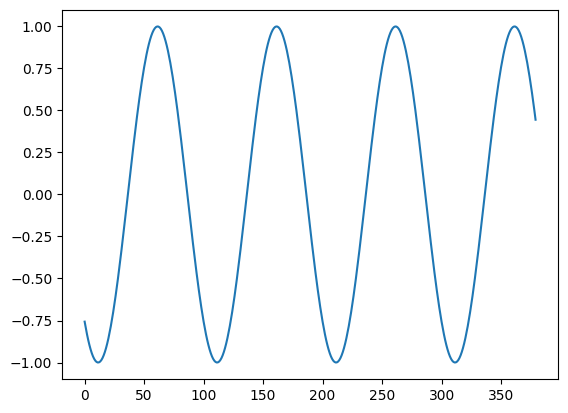

In [3]:
y=sinne(380,sf=0.1,f=1,phase=4)
plt.plot(y)

Y ahora el generador de datos. Le decimos que nos devuelva un batch de datos y nos lo da.

In [4]:
class Data(Dataset):
    #esta es la clase de los datos que seran secuencias de senos de freq aleatoria 
    def __init__(self,lenght,num_samples,amp_random=True,freq_random=True,phase_random=True,sf=0.1):
        super().__init__()
        self.amp_random=amp_random
        self.freq_random=freq_random
        self.phase_random=phase_random
        self.num_samples=num_samples
        self.sf=0.1
        self.lenght=lenght

    def __len__(self):

        return self.num_samples


    def __getitem__(self, index):
        amp=float(np.random.randint(1,300,1)*0.01)
        phase=np.random.randint(0,100,1)*0.02
        f=np.random.randint(1,200,1)*0.01
        y=sinne(lenght=self.lenght,amp=amp,sf=0.1,f=f,phase=phase)
        y=y.unsqueeze(-1)
        return y


In [5]:
win_size=600
data=Data(win_size,4000)

dataloader=DataLoader(data,batch_size=32,shuffle=True)

No es todo lo personalizable que querria, pero bien, ahora creamos la red. 

In [80]:
modelo=AnomalyTransformer.AnomalyTransformer(win_size, 1, 1, d_model=32, n_heads=2, e_layers=1, d_ff=32,
                          dropout=0.0, activation='gelu', output_attention=True)
modelo.cuda()


AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=32, out_features=32, bias=True)
          (key_projection): Linear(in_features=32, out_features=32, bias=True)
          (value_projection): Linear(in_features=32, out_features=32, bias=True)
          (sigma_projection): Linear(in_features=32, out_features=2, bias=True)
          (out_projection): Linear(in_features=32, out_features=32, bias=Tru

In [7]:
def warmup_and_decay_learning_rate(optimizer, epoch, init_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        lr = init_lr * (epoch / warmup_epochs)
        print('Warmup: Updating learning rate to {}'.format(lr))
    else:
        decay_epochs = total_epochs - warmup_epochs
        decay_rate = 1e-7+(epoch - warmup_epochs) / decay_epochs
        lr = init_lr * (1 - decay_rate)
        print('Decay: Updating learning rate to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr




def count_parameters(model):
    
    total=sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total}")
    return total
count_parameters(modelo)

Total trainable parameters: 6853


6853

## Entrenamiento
Añadimos en el entrenamiendo dos fases, una de mini y otra de max

Con el output tenemos que sacar: el error de reconstrucción y el AssDiss, y luego sacar dos function loses, una donde se minimiza y otra donde de maximiza.  

El calculo de las assdis lo vamos a poner en una funcion. 

In [8]:
def layer_association_discrepancy( Pl, Sl):
    rowwise_kl = lambda row: (
        F.kl_div(Pl[row, :], Sl[row, :]) + F.kl_div(Sl[row, :], Pl[row, :])
    )
    ad_vector = torch.concat(
        [rowwise_kl(row).unsqueeze(0) for row in range(Pl.shape[0])]
    )
    return ad_vector

def association_discrepancy( P_list, S_list):

    return (1 / len(P_list)) * sum(
        [
            layer_association_discrepancy(P, S)
            for P, S in zip(P_list, S_list)
        ]
    )

def loss_function( x_hat, P_list, S_list, lambda_, x):
    frob_norm = torch.linalg.matrix_norm(x_hat - x, ord="fro")
    return frob_norm - (
        lambda_
        * torch.linalg.norm(association_discrepancy(P_list, S_list), ord=1)
    )

def min_loss(output,P_layers,S_layers, x,lambda_):
    P_list = P_layers
    S_list = [S.detach() for S in S_layers]
    lambda_ = -lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

def max_loss(output,P_layers,S_layers,x,lambda_):
    P_list = [P.detach() for P in P_layers]
    S_list = S_layers
    lambda_ = lambda_
    return loss_function(output, P_list, S_list, lambda_, x)

In [59]:
x_aux=next(iter(dataloader))
x_aux=x_aux.float().cuda()
print(x_aux.shape)

torch.Size([32, 600, 1])


In [81]:
#pruebas porque salen nans
y_aux,series,prior,_=modelo(x_aux)
print(y_aux.shape)


torch.Size([32, 600, 1])


In [82]:
print(series[0].shape)

torch.Size([32, 2, 600, 600])


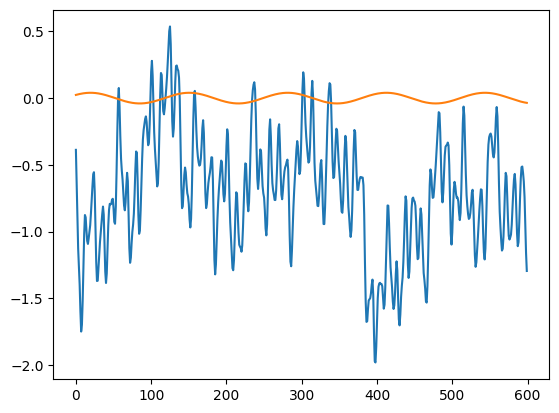

In [62]:
plt.plot(y_aux[7].squeeze().detach().cpu().numpy())
plt.plot(x_aux[7].squeeze().detach().cpu().numpy())

¿¿COmo aplicar esto si tenemos batches y heads??

/home/arturoSF/.conda/envs/pytorch/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


torch.Size([600])


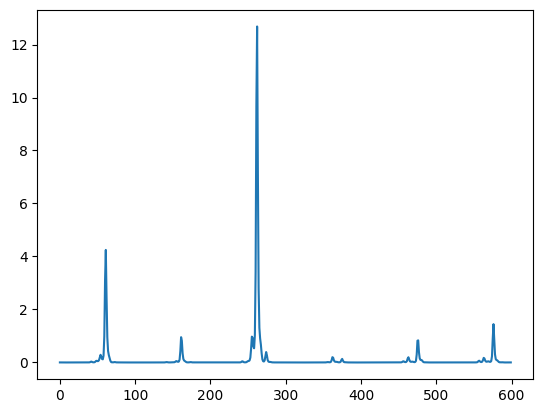

In [101]:
assdis=layer_association_discrepancy(prior[0][0,0],series[0][0,0])
print(assdis.shape)
plt.plot(assdis.detach().cpu().numpy())

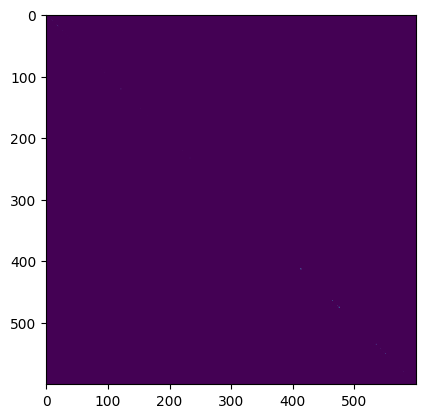

In [46]:
plt.imshow(series[0][0,3].detach().cpu())

In [9]:
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)
modelo.train()
lambda_=3

# Entrenamiento
num_epochs = 60
for epoch in range(num_epochs):
    for i, (inputs) in enumerate(dataloader):
        # Forward
        inputs=inputs.float().to("cuda:0")
        outputs, series, prior, _ = modelo(inputs)

        loss_min = min_loss(outputs,prior,series, inputs,lambda_).mean()
        loss_max = max_loss(outputs,prior,series, inputs,lambda_).mean()

        # Backward y optimización
        loss_min.backward(retain_graph=True)
        loss_max.backward()
        optimizer.step()
        optimizer.zero_grad()
        del inputs 
        torch.cuda.empty_cache()
        gc.collect()

        warmup_and_decay_learning_rate(optimizer, epoch, 1e-2,15 , num_epochs)
        # Printear resultados
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss_min: {loss_min.item():.4f}, Loss_max: {loss_max.item():.4f}")

print("Entrenamiento finalizado")

/home/arturoSF/.conda/envs/pytorch/lib/python3.11/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [1/125], Loss_min: 2414.2266, Loss_max: -2352.1855
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [2/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [3/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [4/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [5/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [6/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [7/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [8/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [9/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.0
Epoch [1/60], Step [10/125], Loss_min: nan, Loss_max: nan
Warmup: Updating learning rate to 0.

KeyboardInterrupt: 

In [12]:
a

tensor([[[ 1.0810],
         [ 1.1176],
         [ 1.1521],
         ...,
         [ 1.2557],
         [ 1.2294],
         [ 1.2006]],

        [[ 2.2770],
         [ 2.2625],
         [ 2.2454],
         ...,
         [-0.0574],
         [-0.1358],
         [-0.2140]],

        [[ 2.9199],
         [ 2.9117],
         [ 2.8908],
         ...,
         [-0.6491],
         [-0.8358],
         [-1.0189]],

        ...,

        [[ 2.6844],
         [ 2.6486],
         [ 2.6067],
         ...,
         [-2.2721],
         [-2.1935],
         [-2.1099]],

        [[ 2.3499],
         [ 2.3005],
         [ 2.1627],
         ...,
         [-1.2875],
         [-0.8793],
         [-0.4372]],

        [[ 2.7049],
         [ 2.7919],
         [ 2.8438],
         ...,
         [-2.2256],
         [-2.0106],
         [-1.7702]]], dtype=torch.float64)

In [21]:
del modelo
del inputs
torch.cuda.empty_cache()
gc.collect()

2639

In [24]:
modelo.cuda()
a=next(iter(dataloader))
a1=a.float().to("cuda:0")
modelo.eval()
y=modelo(a1)


OutOfMemoryError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 7.93 GiB total capacity; 4.21 GiB already allocated; 119.19 MiB free; 4.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
y[0]

tensor([[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [48]:
torch.cuda.empty_cache()
import gc
gc.collect()

920

In [19]:
z=y[0].squeeze().cpu().detach().numpy()
z1=y[1][0].squeeze().cpu().detach().numpy()
z2=y[2][0].squeeze().cpu().detach().numpy()
b=a[1].squeeze().cpu().detach().numpy()

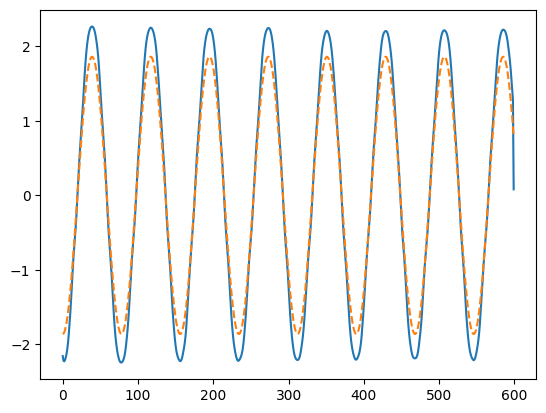

In [20]:
plt.plot(z[18])
plt.plot(b[18],"--")

In [ ]:
z1.shape

(32, 600, 600)

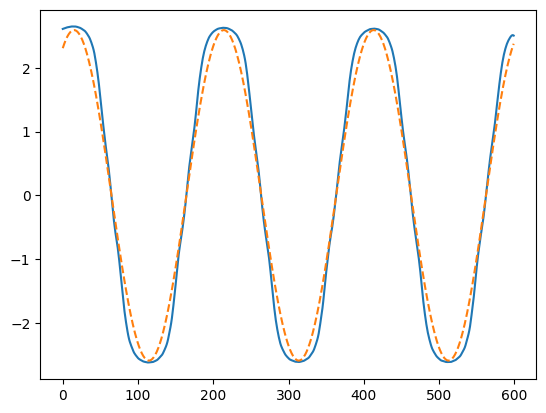

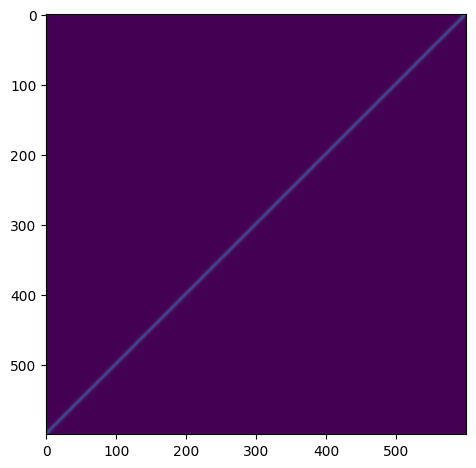

In [22]:
n=9

plt.plot(z[n])
plt.plot(b[n],"--")
plt.figure(figsize=(12,12))
for i in range(1):
    plt.subplot(2,2,i+1)
    plt.imshow(z1[i])